In [1]:
%load_ext autoreload

%autoreload 2
import sys
import corner
import numpy as np
import matplotlib.pyplot as plt
import scipy
import astropy.units as u
def binning(corner): return [[corner[i],corner[i+1]] for i in range(len(corner)-1)]
sys.path.append('/pbs/throng/lsst/users/cpayerne/LikelihoodsClusterAbundance/modules/')
import unbinned_model_hybrid as hybrid
import unbinned_model as unbinned
import pyccl as ccl
import edit
import pandas as pd
import h5py, glob
from astropy.coordinates import SkyCoord
from astropy.table import Table
Omega_c_true = 0.30711 - 0.048254
Omega_b_true = 0.048254
sigma8_true = .8288
Omegam_true = 0.30711
True_value = [Omega_c_true + Omega_b_true, sigma8_true]

/pbs/home/c/cpayerne/.conda/envs/myenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
cosmo = ccl.Cosmology(Omega_c = Omegam_true - 0.048254, Omega_b = 0.048254, 
                              h = 0.6777, sigma8 = sigma8_true, n_s=0.96)

In [3]:
z_grid = np.linspace(.2, 1.2, 500)
logm_grid = np.linspace(14.2, 15.6, 501)
fsky =1
redshift_intervals = np.linspace(0.2, 1.2, 5)
redshift_intervals = [[redshift_intervals[i], redshift_intervals[i+1]] for i in range(len(redshift_intervals)-1)]

In [4]:
mapping = unbinned.Mapping()
mapping.set_cosmology(cosmo)
sigma2_map = mapping.compute_sigma2_map(z_grid, fsky)

In [5]:
dN_dlogmdz_map = mapping.compute_dN_dlogMdzdOmega_map(z_grid, logm_grid, fsky)
halo_bias_map = mapping.compute_halo_bias_map(z_grid, logm_grid)
mapping.interp(z_grid, logm_grid, sigma2_map, dN_dlogmdz_map, halo_bias_map)

In [6]:
mapping_hybrid = hybrid.Mapping()
mapping_hybrid.set_cosmology(cosmo)
Sij_partialsky_hybrid = mapping_hybrid.compute_Sij_map(redshift_intervals, fsky)
dN_dlogmdz_map = mapping_hybrid.compute_dN_dlogMdzdOmega_map(z_grid, logm_grid, fsky)
Nth =mapping_hybrid.compute_N_th(z_grid, logm_grid, dN_dlogmdz_map)
halo_bias_map = mapping_hybrid.compute_halo_bias_map(z_grid, logm_grid)
mapping_hybrid.compute_bdNdm_zbins_and_dNdm_zbins(z_grid, logm_grid, 
                                                   dN_dlogmdz_map, halo_bias_map, 
                                                   redshift_intervals, fsky)
mapping_hybrid.compute_Nb_zbins(z_grid, logm_grid, 
                                 dN_dlogmdz_map, halo_bias_map, 
                                 redshift_intervals, fsky)
mapping_hybrid.interp(z_grid, logm_grid, dN_dlogmdz_map, halo_bias_map, 
                       redshift_intervals, Sij_partialsky_hybrid, fsky)

In [7]:
where_cat = '/sps/lsst/users/cpayerne/1000xsimulations/1000_simulations/afumagalli/catalogs/plc_14/*'
cat = glob.glob(where_cat)
cat_test = pd.read_csv(cat[35] ,sep=' ',skiprows=12, names=['M','z','dec','ra'])
ra, dec, redshift, Mvir = cat_test['ra'], cat_test['dec'], cat_test['z'], cat_test['M']/0.6777
mask = (redshift > .2)&(redshift < 1.2)
mask = mask &(np.log10(Mvir) > 14.2)&(np.log10(Mvir) < 15.6)
redshift_cut = redshift[mask]
Mvir_cut = Mvir[mask]
z_sample = redshift_cut
logm_sample = np.log10(Mvir_cut)

In [8]:
len(z_sample)

95471

In [9]:
b2S_hybrid = []
for i, redshift_range_1 in enumerate(redshift_intervals):
    mask_redshift_1 = (z_sample > redshift_range_1[0])*(z_sample < redshift_range_1[1])
    Sb2_sample_i = list(mapping_hybrid.halo_bias_zbins[i](logm_sample[mask_redshift_1]) **2 * Sij_partialsky_hybrid[i,i])
    b2S_hybrid += Sb2_sample_i

In [10]:
b_sample = mapping.b_map_interp_fct(logm_sample, z_sample, grid = False)
sigma2_sample = mapping.sigma2_interp_fct(z_sample, z_sample, grid = False)
b2S_unbinned = b_sample**2 * sigma2_sample

In [11]:
varbdelta = np.logspace(np.log10(0.000001), np.log10(10), 200)

In [12]:
def Gauss(x, mu, sigma):
    return np.exp(-(x-mu)**2/(2*sigma**2))/(np.sqrt(2*np.pi*sigma**2))

In [13]:
proba_inf = []
x = np.linspace(-10, 10, 1000)
mask_pos = x < -1
for i in range(len(varbdelta)):
    y = Gauss(x, 0, varbdelta[i]**.5)
    res = np.trapz(y[mask_pos], x[mask_pos])
    proba_inf.append(res)

In [15]:
len(b2S_unbinned)

95471

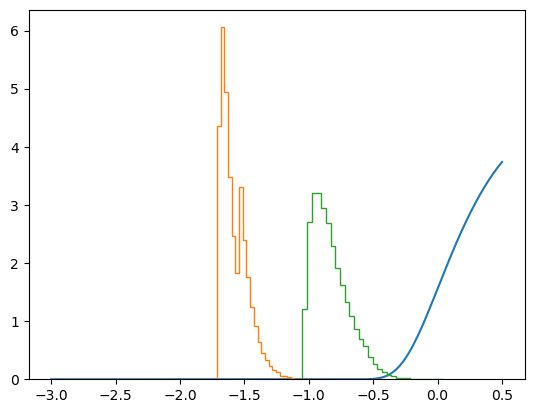

In [43]:
fsky = 1/100
plt.plot(np.log10(varbdelta**.5), 10*np.array(proba_inf))
plt.hist(np.log10((np.array(b2S_hybrid)/fsky)**.5), bins=30, density = True, histtype='step')
plt.hist(np.log10((np.array(b2S_unbinned)/fsky)**.5), bins=30, density = True, histtype='step')
#plt.xlim(-6, -1)

plt.show()